<a href="https://colab.research.google.com/github/Win10kc/handwritten-character-recognition/blob/main/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import kagglehub
from scipy.ndimage import rotate

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Download MNIST dataset from Kaggle
path = kagglehub.dataset_download("oddrationale/mnist-in-csv")
print("Path to dataset files:", path)

# Load the dataset
train_path = os.path.join(path, "mnist_train.csv")
test_path = os.path.join(path, "mnist_test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Extract labels and pixel values
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

# MNIST has 10 classes (digits 0-9)
num_classes = 10

# Reshape and preprocess the data
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')

# Preprocessing: Rotate, flip, normalize
def preprocess_images(images):
    images_rotated = np.array([rotate(img, angle=90, reshape=False) for img in images])
    images_flipped = images_rotated[:, :, ::-1, :]
    images_normalized = images_flipped / 255.0
    return images_normalized

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define AlexNet model
def create_alexnet():
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(96, (11, 11), strides=4, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        BatchNormalization(),
        Conv2D(256, (5, 5), strides=1, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(384, (3, 3), strides=1, activation='relu', padding='same'),
        Conv2D(384, (3, 3), strides=1, activation='relu', padding='same'),
        Conv2D(256, (3, 3), strides=1, activation='relu', padding='same'),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile AlexNet
alexnet = create_alexnet()
alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
alexnet.summary()

# Callback to save the best model
checkpoint = ModelCheckpoint('best_alexnet.h5', monitor='val_loss', save_best_only=True, mode='min')

# Measure training time
start_time = time.time()

# Train the model
history = alexnet.fit(X_train, y_train, batch_size=128, epochs=10,
                      validation_data=(X_test, y_test), callbacks=[checkpoint])

# Calculate training time
end_time = time.time()
training_time = end_time - start_time
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nAlexNet Training Time: {int(hours)} hours {int(minutes)} minutes {int(seconds)} seconds")

# Evaluate model
y_pred = alexnet.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print("\nAlexNet Evaluation Metrics:")
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1:.5f}")

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('AlexNet Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('alexnet_confusion_matrix.png')
plt.close()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AlexNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('alexnet_training_history.png')
plt.close()

Path to dataset files: /kaggle/input/mnist-in-csv


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 7, 7, 96)       │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,599,306 (82.39 MB)

 Trainable params: 21,599,114 (82.39 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7712 - loss: 0.6253

469/469 ━━━━━━━━━━━━━━━━━━━━ 642s 1s/step - accuracy: 0.7714 - loss: 0.6246 - val_accuracy: 0.9601 - val_loss: 0.1458
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9757 - loss: 0.0957

469/469 ━━━━━━━━━━━━━━━━━━━━ 651s 1s/step - accuracy: 0.9757 - loss: 0.0957 - val_accuracy: 0.9790 - val_loss: 0.0891
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.9815 - loss: 0.0778 - val_accuracy: 0.9749 - val_loss: 0.1100
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.9859 - loss: 0.0598 - val_accuracy: 0.9732 - val_loss: 0.1327
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.9881 - loss: 0.0496 - val_accuracy: 0.9835 - val_loss: 0.0902
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.9884 - loss: 0.0500 - val_accuracy: 0.9770 - val_loss: 0.1011
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9915 - loss: 0.0377

469/469 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.9915 - loss: 0.0377 - val_accuracy: 0.9852 - val_loss: 0.0748
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.9925 - loss: 0.0292 - val_accuracy: 0.9784 - val_loss: 0.1050
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.9928 - loss: 0.0335 - val_accuracy: 0.9819 - val_loss: 0.0976
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 643s 1s/step - accuracy: 0.9932 - loss: 0.0291 - val_accuracy: 0.9851 - val_loss: 0.0828

AlexNet Training Time: 1 hours 52 minutes 8 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step

AlexNet Evaluation Metrics:
Accuracy: 0.98510
Precision: 0.98523
Recall: 0.98510
F1-score: 0.98510


In [ ]:
# Xem 5 ảnh đầu tiên và nhãn của chúng
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.suptitle("5 Mẫu Ảnh Đầu Tiên Trong Tập Huấn Luyện", fontsize=14)
plt.tight_layout()
plt.savefig("sample_training_images.png")
plt.close()


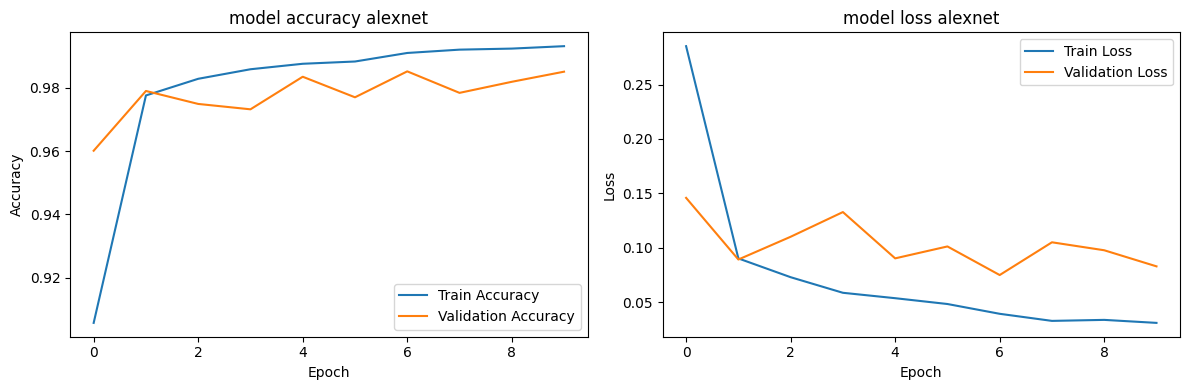

In [ ]:
# Hiển thị đồ thị Training Accuracy và Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model accuracy alexnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss alexnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
